In [2]:
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2023-08-26 23:15:29.299701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
directory = "Dataset_BUSI_with_GT"
files = os.listdir(directory)
print(files)

['malignant', 'benign', 'normal']


In [4]:
# Define the directory containing the dataset
dataset_dir = 'Dataset_BUSI_with_GT'

# Get a list of all the image filenames
filenames = os.listdir(dataset_dir)

# Print the number of images in the dataset
print(f"Number of images: {len(filenames)}")

Number of images: 3


In [5]:
img_dir = "Dataset_BUSI_with_GT"
classes = ['malignant', 'benign', 'normal']

### Image Preprocessing

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2

# Define the path to the main folder containing the subfolders for each category
main_folder_path = "Dataset_BUSI_with_GT"

# List all subfolders (categories) in the main folder
categories = ['malignant', 'benign', 'normal']

# Denoising function using Gaussian filter
def denoise_image(image):
    return cv2.GaussianBlur(image, (3, 3), 0)

# Data augmentation settings
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image resizing settings
target_size = (256, 256)  # Set the desired target size

# Initialize lists to store image data and corresponding labels
images = []
labels = []

# Loop through each category
for i, category in enumerate(categories):
    category_folder = os.path.join(main_folder_path, category)

    # Loop through each image file in the category folder
    for image_file in os.listdir(category_folder):
        image_path = os.path.join(category_folder, image_file)

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply denoising
        denoised_image = denoise_image(image)

        # Resize the image
        resized_image = cv2.resize(denoised_image, target_size)

        # Append the resized image and corresponding label to the lists
        images.append(resized_image)
        labels.append(i)  # Assign label index based on the category index

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and test sets (80% training, 20% test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Ensure that the values of images and labels are within the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

### Image Visualization

In [53]:
# Load the images and create the labels

main_folder_path = "Dataset_BUSI_with_GT"
categories = ['malignant', 'benign', 'normal']
image_size = (256, 256)

images = []
labels = []

for category_index, category in enumerate(categories):
    folder_path = os.path.join(main_folder_path, category)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        images.append(image)
        labels.append(category_index)

images = np.array(images)
labels = np.array(labels)

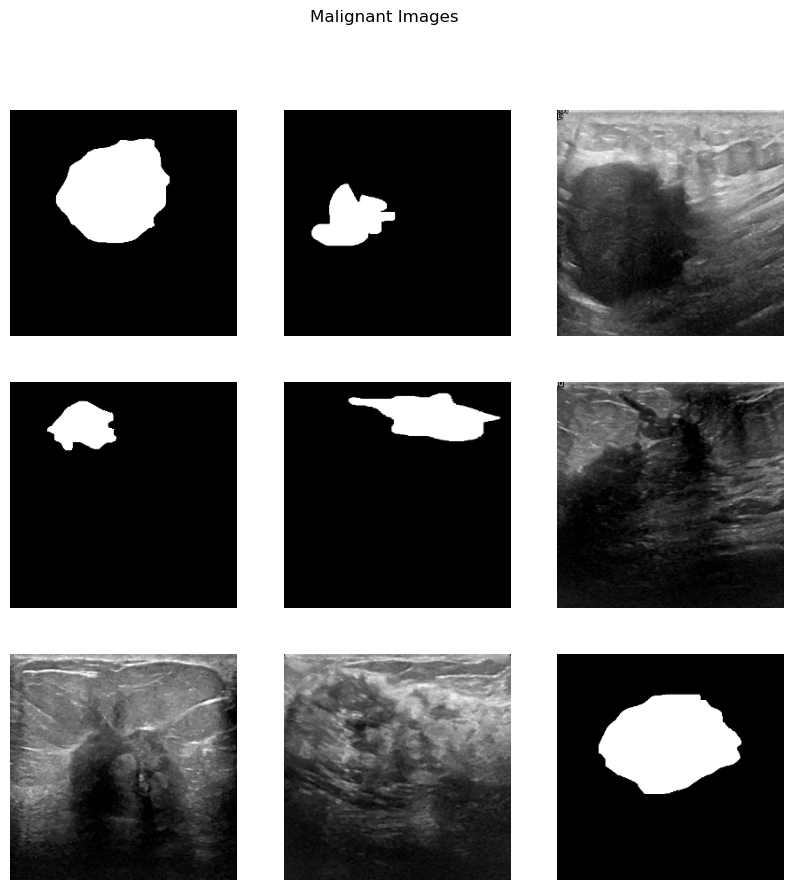

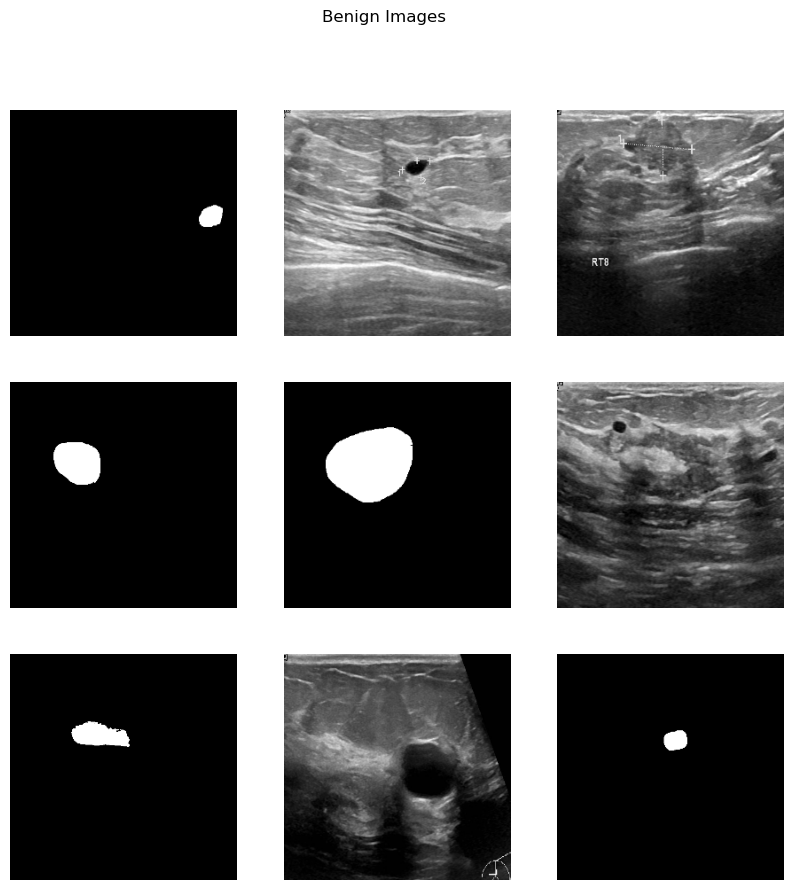

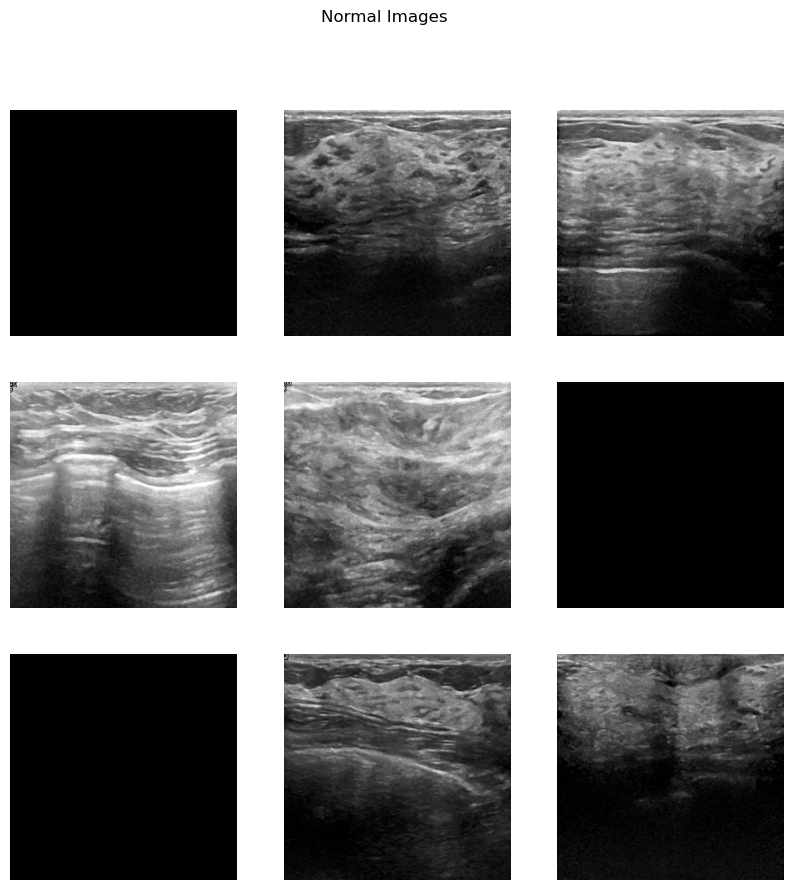

In [54]:
# Function to load and preprocess images
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        images.append(image)
    return images

# Create a grid of images for each category
num_rows = 3
num_cols = 3

for category in categories:
    folder_path = os.path.join(main_folder_path, category)
    images = load_images(folder_path)
    plt.figure(figsize=(10, 10))
    for i in range(min(num_rows * num_cols, len(images))):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(category.capitalize() + " Images")
    plt.show()

In [12]:
def create_xception_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def create_resnet50v2_model(input_shape, num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [13]:
def create_concatenated_model(input_shape, num_classes):
    xception_model = create_xception_model(input_shape, num_classes)
    resnet50v2_model = create_resnet50v2_model(input_shape, num_classes)

    for layer in xception_model.layers:
        layer.trainable = False

    for layer in resnet50v2_model.layers:
        layer.trainable = False

    concatenated_layers = Concatenate()([xception_model.output, resnet50v2_model.output])
    x = Dense(512, activation='relu')(concatenated_layers)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[xception_model.input, resnet50v2_model.input], outputs=predictions)
    return model

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import Xception, ResNet50V2
from keras.layers import GlobalAveragePooling2D, concatenate, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

# Preprocess the grayscale images to have three channels
train_images_rgb = np.stack((train_images,) * 3, axis=-1)

#Split dataset into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images_rgb, train_labels, test_size=0.2, random_state=42
)

#Build the Xception model
def create_xception_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#Build the ResNet50V2 model
def create_resnet50v2_model(input_shape, num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#Concatenate Xception and ResNet50V2 models
def create_concatenated_model(xception_model, resnet50v2_model, num_classes):
    xception_output = xception_model.output
    resnet50v2_output = resnet50v2_model.output

    concatenated_features = concatenate([xception_output, resnet50v2_output])
    x = Dense(512, activation='relu')(concatenated_features)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[xception_model.input, resnet50v2_model.input], outputs=predictions)
    return model

# Create and compile the model
input_shape = train_images[0].shape  
num_classes = 3  

# Ensure input_shape includes the channel dimension
xception_model = create_xception_model(input_shape, num_classes)
resnet50v2_model = create_resnet50v2_model(input_shape, num_classes)
model = create_concatenated_model(xception_model, resnet50v2_model, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([train_images, train_images], to_categorical(train_labels), batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate([test_images, test_images], to_categorical(test_labels))
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

2023-08-04 00:07:06.770351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
29/29 [==============================] - 663s 23s/step - loss: 0.9075 - accuracy: 0.5837 - val_loss: 0.9864 - val_accuracy: 0.5545
Epoch 2/10
29/29 [==============================] - 641s 22s/step - loss: 0.7669 - accuracy: 0.6443 - val_loss: 0.8808 - val_accuracy: 0.6436
Epoch 3/10
29/29 [==============================] - 596s 21s/step - loss: 0.7297 - accuracy: 0.6597 - val_loss: 1.1443 - val_accuracy: 0.5545
Epoch 4/10
29/29 [==============================] - 577s 20s/step - loss: 0.6703 - accuracy: 0.6806 - val_loss: 0.9385 - val_accuracy: 0.6436
Epoch 5/10
29/29 [==============================] - 536s 18s/step - loss: 0.6697 - accuracy: 0.6872 - val_loss: 1.0017 - val_accuracy: 0.6436
Epoch 6/10
29/29 [==============================] - 519s 18s/step - loss: 0.6177 - accuracy: 0.7070 - val_loss: 1.1159 - val_accuracy: 0.6139
Epoch 7/10
29/29 [==============================] - 539s 19s/step - loss: 0.5889 - accuracy: 0.6982 - val_loss: 0.8983 - val_accuracy: 0.4752
Epoch 

### Hyperparameter Model of Concatenation of ResNet50V2 and Xceptiom

In [33]:
def create_concatenated_model_hyper(input_shape, num_classes, dropout_rate=0.5, dense_units=256):
    xception_model = create_xception_model(input_shape, num_classes)
    resnet50v2_model = create_resnet50v2_model(input_shape, num_classes)

    for layer in xception_model.layers:
        layer.trainable = False

    for layer in resnet50v2_model.layers:
        layer.trainable = False

    x1 = xception_model.output
    x2 = resnet50v2_model.output
    x = concatenate([x1, x2])
    
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    concatenated_model = Model(inputs=[xception_model.input, resnet50v2_model.input], outputs=output)
    concatenated_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return concatenated_model

Epoch 1/10
29/29 [==============================] - 584s 20s/step - loss: 0.6186 - accuracy: 0.7313 - val_loss: 28604.6582 - val_accuracy: 0.2772
Epoch 2/10
29/29 [==============================] - 527s 18s/step - loss: 0.3834 - accuracy: 0.8480 - val_loss: 486.4167 - val_accuracy: 0.5446
Epoch 3/10
29/29 [==============================] - 487s 17s/step - loss: 0.2789 - accuracy: 0.9020 - val_loss: 1.7930 - val_accuracy: 0.8218
Epoch 4/10
29/29 [==============================] - 499s 17s/step - loss: 0.1621 - accuracy: 0.9449 - val_loss: 38.9017 - val_accuracy: 0.6634
Epoch 5/10
29/29 [==============================] - 483s 17s/step - loss: 0.1419 - accuracy: 0.9604 - val_loss: 1.5643 - val_accuracy: 0.7525
Epoch 6/10
29/29 [==============================] - 475s 16s/step - loss: 0.1839 - accuracy: 0.9372 - val_loss: 4.4801 - val_accuracy: 0.6931
Epoch 7/10
29/29 [==============================] - 468s 16s/step - loss: 0.1060 - accuracy: 0.9648 - val_loss: 11.1013 - val_accuracy: 0.673

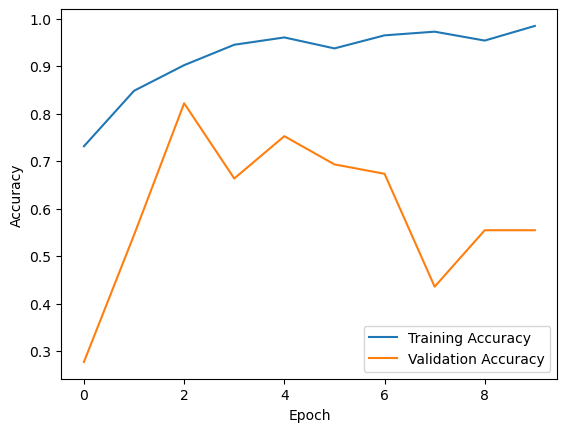

In [34]:
# Train the concatenated model
history = concatenated_model.fit(
    [train_images, train_images],
    to_categorical(train_labels),
    batch_size=32,
    epochs=10,
    validation_split=0.1
)

# Evaluate the model on the test data
loss, accuracy = concatenated_model.evaluate(
    [test_images, test_images],
    to_categorical(test_labels)
)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

8/8 [==============================] - 28s 3s/step
Sensitivity: 0.8214285714285714
Specificity: 0.3582089552238806
Cohen's Kappa: 0.3683393688566994
Classification Report:
              precision    recall  f1-score   support

      benign       0.35      0.77      0.48        60
   malignant       0.80      0.34      0.47       143
      normal       0.79      0.96      0.86        50

    accuracy                           0.56       253
   macro avg       0.65      0.69      0.61       253
weighted avg       0.69      0.56      0.55       253



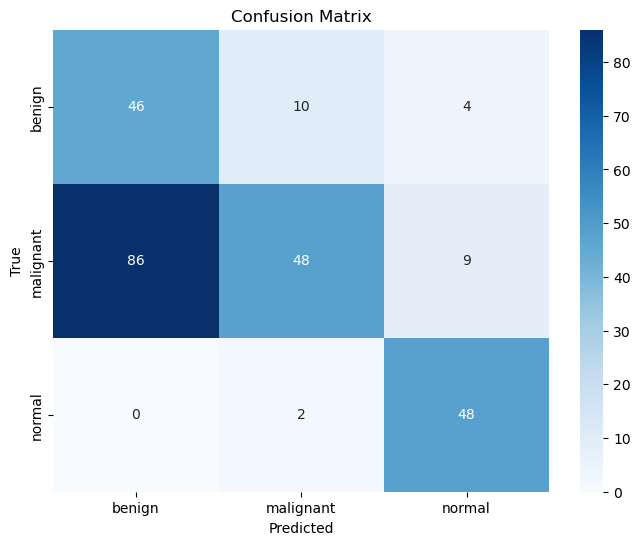

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score



# Get the predicted labels
predicted_labels = concatenated_model.predict([test_images, test_images])
predicted_labels = np.argmax(predicted_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Compute sensitivity and specificity
sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Compute Cohen's Kappa
cohen_kappa = cohen_kappa_score(test_labels, predicted_labels)

# Generate classification report for each class
class_names = ["benign", "malignant", "normal"]
classification_rep = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print sensitivity, specificity, Cohen's Kappa, and classification report
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Cohen's Kappa:", cohen_kappa)
print("Classification Report:")
print(classification_rep)

# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from keras.applications import Xception, ResNet50V2
from keras.layers import GlobalAveragePooling2D, concatenate, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

# Preprocess the grayscale images to have three channels
train_images_rgb = np.stack((train_images,) * 3, axis=-1)

#Split dataset into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images_rgb, train_labels, test_size=0.2, random_state=42
)

#Build the Xception model
def create_xception_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#Build the ResNet50V2 model
def create_resnet50v2_model(input_shape, num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#Concatenate Xception and ResNet50V2 models
def create_concatenated_model(xception_model, resnet50v2_model, num_classes):
    xception_output = xception_model.output
    resnet50v2_output = resnet50v2_model.output

    concatenated_features = concatenate([xception_output, resnet50v2_output])
    x = Dense(512, activation='relu')(concatenated_features)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[xception_model.input, resnet50v2_model.input], outputs=predictions)
    return model

#Create and compile the model
input_shape = train_images[0].shape  # The shape should be (image_height, image_width, num_channels)
num_classes = 3  # Assuming you have 3 classes: benign, malignant, and normal

# Ensure input_shape includes the channel dimension (e.g., (256, 256, 3))
xception_model = create_xception_model(input_shape, num_classes)
resnet50v2_model = create_resnet50v2_model(input_shape, num_classes)
model = create_concatenated_model(xception_model, resnet50v2_model, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
model.fit([train_images, train_images], to_categorical(train_labels), batch_size=32, epochs=10, validation_split=0.1)

#Evaluate the model
loss, accuracy = model.evaluate([test_images, test_images], to_categorical(test_labels))
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

2023-08-01 14:34:58.993751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
23/23 [==============================] - 439s 18s/step - loss: 0.9100 - accuracy: 0.6391 - val_loss: 0.8963 - val_accuracy: 0.6790
Epoch 2/10
23/23 [==============================] - 411s 18s/step - loss: 0.7489 - accuracy: 0.6667 - val_loss: 0.9148 - val_accuracy: 0.3333
Epoch 3/10
23/23 [==============================] - 414s 18s/step - loss: 0.5119 - accuracy: 0.8567 - val_loss: 1.2902 - val_accuracy: 0.5926
Epoch 4/10
23/23 [==============================] - 413s 18s/step - loss: 0.4705 - accuracy: 0.8196 - val_loss: 1.7797 - val_accuracy: 0.2840
Epoch 5/10
23/23 [==============================] - 419s 18s/step - loss: 0.4662 - accuracy: 0.8030 - val_loss: 1.1217 - val_accuracy: 0.7160
Epoch 6/10
23/23 [==============================] - 411s 18s/step - loss: 0.4328 - accuracy: 0.8444 - val_loss: 0.9328 - val_accuracy: 0.7901
Epoch 7/10
23/23 [==============================] - 413s 18s/step - loss: 0.3465 - accuracy: 0.8871 - val_loss: 1.2109 - val_accuracy: 0.6914
Epoch 

In [23]:
#Calculate training accuracy
train_loss, train_accuracy = model.evaluate([train_images, train_images], to_categorical(train_labels))
print(f'Training loss: {train_loss}, Training accuracy: {train_accuracy}')

26/26 [==============================] - 88s 3s/step - loss: 0.5429 - accuracy: 0.8513
Training loss: 0.5429005026817322, Training accuracy: 0.8513011336326599


In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
hisory= model.fit([train_images, train_images], to_categorical(train_labels), batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
23/23 [==============================] - 406s 17s/step - loss: 0.1863 - accuracy: 0.9477 - val_loss: 1.0465 - val_accuracy: 0.7407
Epoch 2/10
23/23 [==============================] - 410s 18s/step - loss: 0.2108 - accuracy: 0.9408 - val_loss: 1.1770 - val_accuracy: 0.7037
Epoch 3/10
23/23 [==============================] - 415s 18s/step - loss: 0.1550 - accuracy: 0.9628 - val_loss: 0.6396 - val_accuracy: 0.8025
Epoch 4/10
23/23 [==============================] - 408s 18s/step - loss: 0.1360 - accuracy: 0.9711 - val_loss: 0.3736 - val_accuracy: 0.9136
Epoch 5/10
23/23 [==============================] - 406s 18s/step - loss: 0.1564 - accuracy: 0.9573 - val_loss: 0.6731 - val_accuracy: 0.8148
Epoch 6/10
23/23 [==============================] - 392s 17s/step - loss: 0.1227 - accuracy: 0.9738 - val_loss: 1.5003 - val_accuracy: 0.5556
Epoch 7/10
23/23 [==============================] - 426s 18s/step - loss: 0.2459 - accuracy: 0.9325 - val_loss: 0.7812 - val_accuracy: 0.7901
Epoch 

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical

# Assuming you have already trained the model and obtained the test set

#Evaluate the model
loss, accuracy = model.evaluate([test_images, test_images], to_categorical(test_labels))
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

#Generate predictions on the test set
predicted_probs = model.predict([test_images, test_images])
predicted_labels = np.argmax(predicted_probs, axis=1)

# Generate classification report and confusion matrix
class_names = ["benign", "malignant", "normal"]
classification_rep = classification_report(test_labels, predicted_labels, target_names=class_names)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print("Classification Report:")
print(classification_rep)

print("Confusion Matrix:")
print(conf_matrix)

7/7 [==============================] - 26s 4s/step - loss: 1.0748 - accuracy: 0.6832
Test loss: 1.0747551918029785, Test accuracy: 0.6831682920455933
7/7 [==============================] - 27s 4s/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.44      0.88      0.59        49
   malignant       0.92      0.55      0.68       121
      normal       0.88      0.91      0.89        32

    accuracy                           0.68       202
   macro avg       0.75      0.78      0.72       202
weighted avg       0.80      0.68      0.69       202

Confusion Matrix:
[[43  5  1]
 [52 66  3]
 [ 2  1 29]]


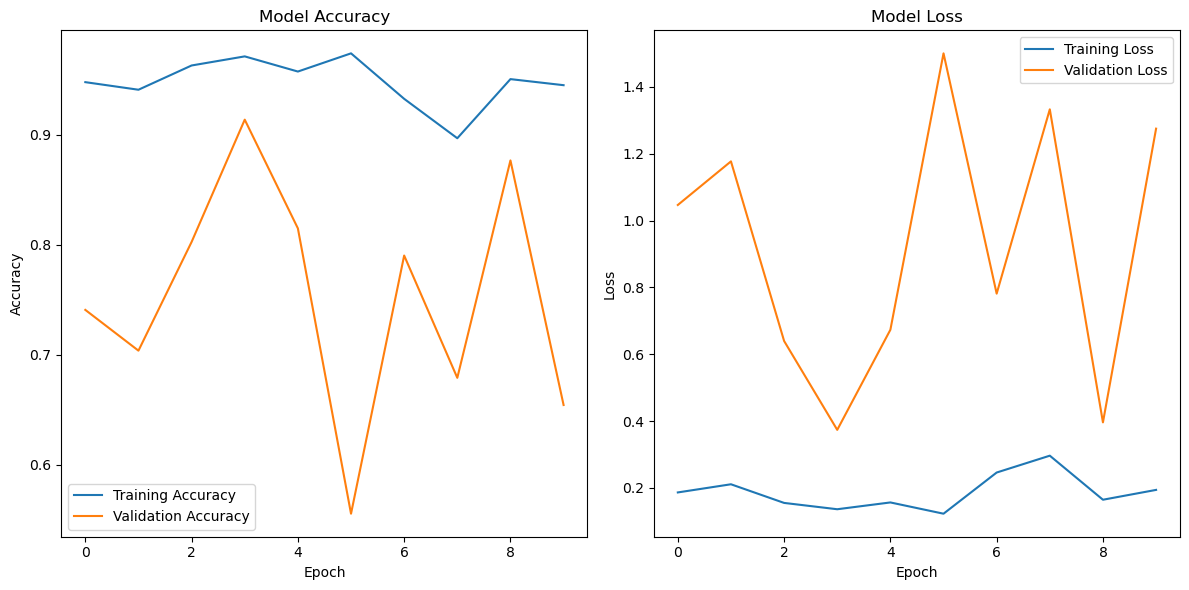

In [36]:
#Plot the test accuracy and loss
plt.figure(figsize=(12, 6))

# Plot test accuracy
plt.subplot(1, 2, 1)
plt.plot(hisory.history['accuracy'], label='Training Accuracy')
plt.plot(hisory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(hisory.history['loss'], label='Training Loss')
plt.plot(hisory.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

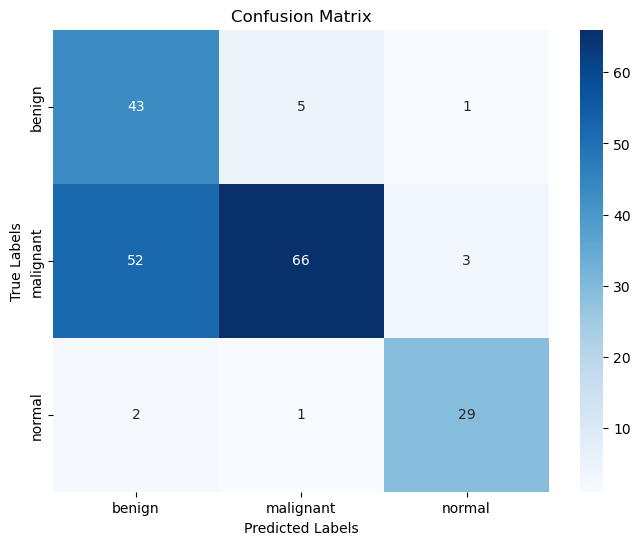

Classification Report:
              precision    recall  f1-score   support

      benign       0.44      0.88      0.59        49
   malignant       0.92      0.55      0.68       121
      normal       0.88      0.91      0.89        32

    accuracy                           0.68       202
   macro avg       0.75      0.78      0.72       202
weighted avg       0.80      0.68      0.69       202



In [35]:
#Visualize the results
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_rep)

### CNN Model

In [39]:
# Define the CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [40]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [41]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, to_categorical(train_labels),
                    batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
23/23 [==============================] - 36s 2s/step - loss: 196.6580 - accuracy: 0.5207 - val_loss: 1.4665 - val_accuracy: 0.6049
Epoch 2/10
23/23 [==============================] - 34s 1s/step - loss: 0.7097 - accuracy: 0.7328 - val_loss: 1.2856 - val_accuracy: 0.6667
Epoch 3/10
23/23 [==============================] - 33s 1s/step - loss: 0.5046 - accuracy: 0.8113 - val_loss: 1.4177 - val_accuracy: 0.6296
Epoch 4/10
23/23 [==============================] - 33s 1s/step - loss: 0.3520 - accuracy: 0.8457 - val_loss: 1.4019 - val_accuracy: 0.6914
Epoch 5/10
23/23 [==============================] - 33s 1s/step - loss: 0.2294 - accuracy: 0.9063 - val_loss: 1.5825 - val_accuracy: 0.6296
Epoch 6/10
23/23 [==============================] - 34s 1s/step - loss: 0.4171 - accuracy: 0.8251 - val_loss: 1.9355 - val_accuracy: 0.6420
Epoch 7/10
23/23 [==============================] - 33s 1s/step - loss: 0.3379 - accuracy: 0.8609 - val_loss: 2.5854 - val_accuracy: 0.6543
Epoch 8/10
23/23 [

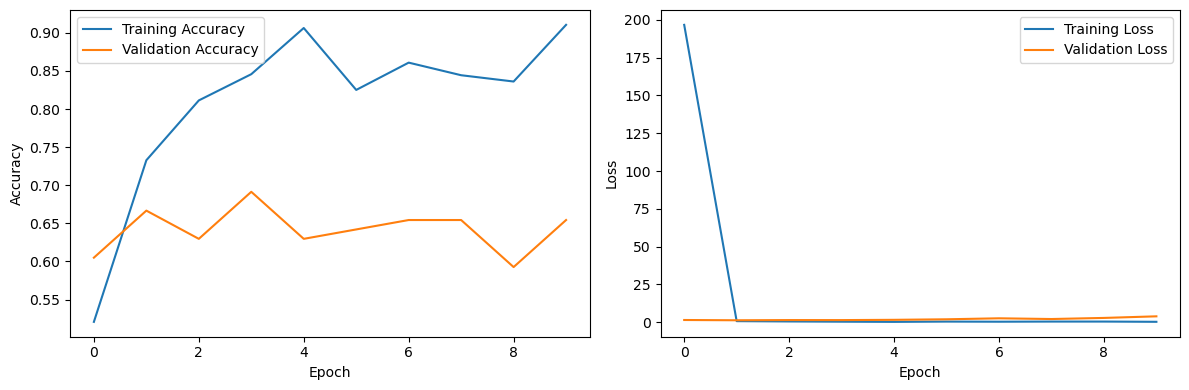

7/7 [==============================] - 3s 365ms/step - loss: 2.3159 - accuracy: 0.6287
Test loss: 2.3159, Test accuracy: 0.6287
7/7 [==============================] - 3s 347ms/step


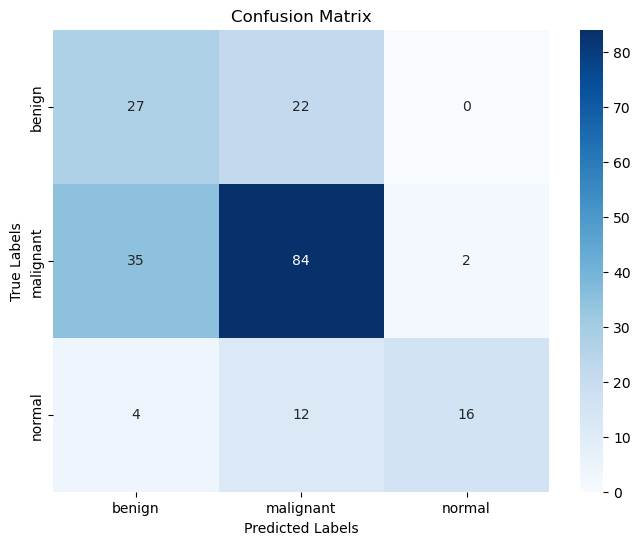

Classification Report:
              precision    recall  f1-score   support

      benign       0.41      0.55      0.47        49
   malignant       0.71      0.69      0.70       121
      normal       0.89      0.50      0.64        32

    accuracy                           0.63       202
   macro avg       0.67      0.58      0.60       202
weighted avg       0.67      0.63      0.64       202



In [42]:
# Visualize training and test accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, to_categorical(test_labels))
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

# Predict labels on test data
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Generate classification report and confusion matrix
class_names = ["benign", "malignant", "normal"]
classification_rep = classification_report(test_labels, predicted_labels, target_names=class_names)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_rep)

In [46]:
 # Calculate Sensitivity, Specificity, and Cohen's Kappa
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
tp = conf_matrix[1, 1]

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
kappa = (accuracy - (1 - accuracy)) / (1 - (1 - accuracy))

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Sensitivity: 0.7059
Specificity: 0.5510
Cohen's Kappa: 0.4094


### Hyperparameter Tunning for CNN

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [41]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [47]:
batch_size = 32
epochs = 20

history = model.fit_generator(
    datagen.flow(train_images, to_categorical(train_labels), batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(test_images, to_categorical(test_labels))
)

/var/folders/94/y4j_9mcs0vqb9pt81bbkcqp80000gp/T/ipykernel_75066/3463166485.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
31/31 [==============================] - 34s 1s/step - loss: 1.0342 - accuracy: 0.5466 - val_loss: 7.7632 - val_accuracy: 0.5652
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 1.0119 - accuracy: 0.5565 - val_loss: 6.7569 - val_accuracy: 0.5731
Epoch 3/20
31/31 [==============================] - 39s 1s/step - loss: 0.9956 - accuracy: 0.5578 - val_loss: 6.5314 - val_accuracy: 0.5652
Epoch 4/20
31/31 [==============================] - 34s 1s/step - loss: 1.0003 - accuracy: 0.5589 - val_loss: 6.6623 - val_accuracy: 0.5731
Epoch 5/20
31/31 [==============================] - 34s 1s/step - loss: 0.9991 - accuracy: 0.5589 - val_loss: 6.6442 - val_accuracy: 0.5731
Epoch 6/20
31/31 [==============================] - 34s 1s/step - loss: 0.9977 - accuracy: 0.5599 - val_loss: 6.5718 - val_accuracy: 0.5731
Epoch 7/20
31/31 [==============================] - 35s 1s/step - loss: 0.9987 - accuracy: 0.5568 - val_loss: 6.7280 - val_accuracy: 0.5692
Epoch 8/20
31/31 [==

In [49]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_images, to_categorical(test_labels))
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Make predictions on the test dataset
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Compute sensitivity and specificity for each class
sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Compute Cohen's Kappa
cohen_kappa = cohen_kappa_score(test_labels, predicted_labels)

# Generate classification report for each class
class_names = ["benign", "malignant", "normal"]
classification_rep = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print sensitivity, specificity, Cohen's Kappa, and classification report
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Cohen's Kappa:", cohen_kappa)
print("Classification Report:")
print(classification_rep)

8/8 [==============================] - 2s 251ms/step - loss: 6.8351 - accuracy: 0.5652
Test loss: 6.835118293762207
Test accuracy: 0.5652173757553101
8/8 [==============================] - 2s 244ms/step
Sensitivity: 0.05
Specificity: 0.9790209790209791
Cohen's Kappa: 0.017579779723241984
Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.05      0.09        60
   malignant       0.57      0.98      0.72       143
      normal       0.00      0.00      0.00        50

    accuracy                           0.57       253
   macro avg       0.36      0.34      0.27       253
weighted avg       0.44      0.57      0.43       253



/Users/jomilojuuuu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jomilojuuuu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jomilojuuuu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


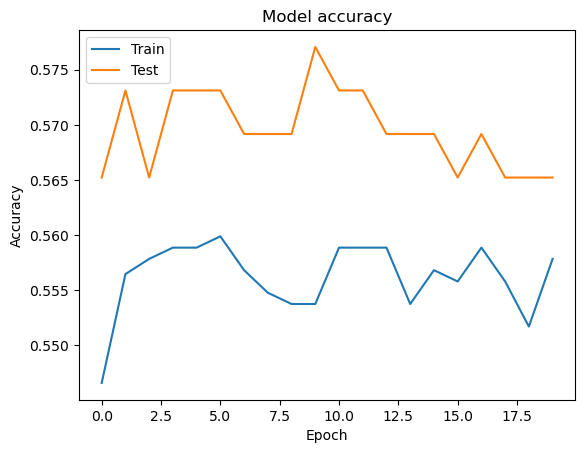

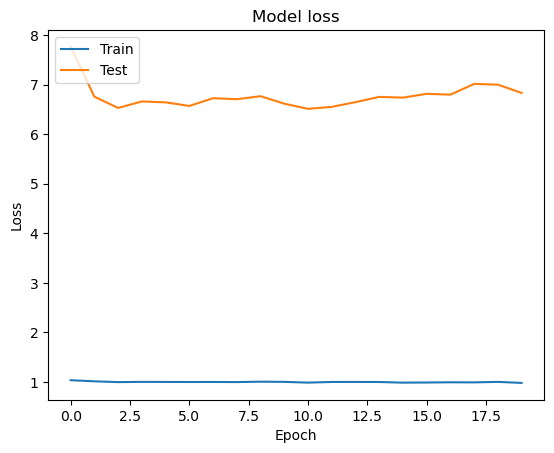

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Logistic Regression model

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sns

In [48]:
# Reshape images to 1D array (flatten)
train_images_flatten = train_images.reshape(train_images.shape[0], -1)
test_images_flatten = test_images.reshape(test_images.shape[0], -1)

In [49]:
#Create and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(train_images_flatten, train_labels)

/Users/jomilojuuuu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [50]:
#Predict on training and test data
train_predictions = logreg_model.predict(train_images_flatten)
test_predictions = logreg_model.predict(test_images_flatten)

# Step 3: Evaluate the model
train_accuracy = logreg_model.score(train_images_flatten, train_labels)
test_accuracy = logreg_model.score(test_images_flatten, test_labels)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9988
Test Accuracy: 0.5198


In [51]:
#Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(test_labels, test_predictions)
classification_rep = classification_report(test_labels, test_predictions, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[22 23  4]
 [35 69 17]
 [ 3 15 14]]

Classification Report:
              precision    recall  f1-score   support

      benign       0.37      0.45      0.40        49
   malignant       0.64      0.57      0.61       121
      normal       0.40      0.44      0.42        32

    accuracy                           0.52       202
   macro avg       0.47      0.49      0.48       202
weighted avg       0.54      0.52      0.53       202



Cohen's Kappa Score: 0.1766


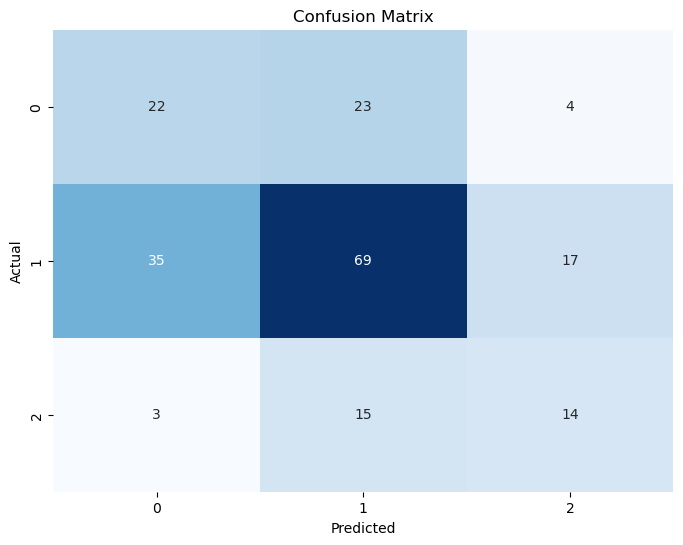

In [52]:
#Cohen's Kappa Score
kappa_score = cohen_kappa_score(test_labels, test_predictions)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

# Step 6: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate sensitivity (recall) and specificity
sensitivity = recall_score(test_labels, test_predictions, average='weighted')
specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]))  # For the 'benign' class

# Print sensitivity and specificity
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

Sensitivity (Recall): 0.5198
Specificity: 0.4889


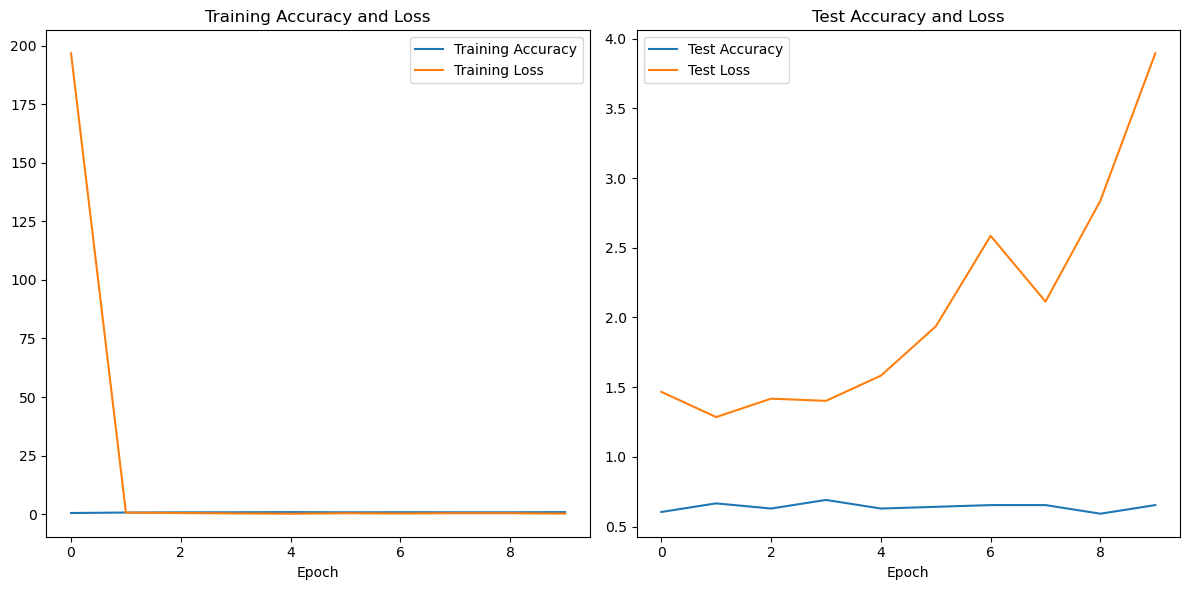

In [53]:
#Visualize Training and Test Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot Training Accuracy and Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training Accuracy and Loss')

# Plot Test Accuracy and Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Test Accuracy and Loss')

plt.tight_layout()
plt.show()

### Hyperparameter Tunning of Logisitc Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/jomilojuuuu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jomilojuuuu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Best Hyperparameters: {'C': 10}
Test Accuracy: 0.5198
Confusion Matrix:
[[25 20  4]
 [32 66 23]
 [ 4 14 14]]

Classification Report:
              precision    recall  f1-score   support

      benign       0.41      0.51      0.45        49
   malignant       0.66      0.55      0.60       121
      normal       0.34      0.44      0.38        32

    accuracy                           0.52       202
   macro avg       0.47      0.50      0.48       202
weighted avg       0.55      0.52      0.53       202

Cohen's Kappa Score: 0.1971


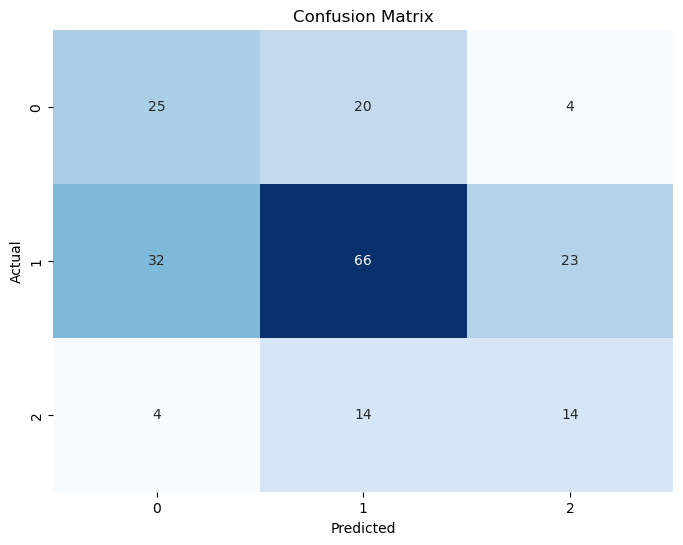

In [55]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {'C': [0.01, 0.1, 1, 10]}

# Create the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Initialize GridSearchCV
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(train_images_flatten, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
test_predictions = best_model.predict(test_images_flatten)

# Evaluate the best model
test_accuracy = best_model.score(test_images_flatten, test_labels)
conf_matrix = confusion_matrix(test_labels, test_predictions)
classification_rep = classification_report(test_labels, test_predictions, target_names=class_names)
kappa_score = cohen_kappa_score(test_labels, test_predictions)

# Print evaluation metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate sensitivity (recall) and specificity
sensitivity = recall_score(test_labels, test_predictions, average='weighted')
specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]))  

# Print sensitivity and specificity
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

Sensitivity (Recall): 0.5198
Specificity: 0.5556


### SVM Model

Test Accuracy: 0.5696
Confusion Matrix:
[[ 36  43   9]
 [ 42 118  27]
 [  4  11  26]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.44      0.41      0.42        88
   malignant       0.69      0.63      0.66       187
      normal       0.42      0.63      0.50        41

    accuracy                           0.57       316
   macro avg       0.51      0.56      0.53       316
weighted avg       0.58      0.57      0.57       316

Cohen's Kappa Score: 0.2582


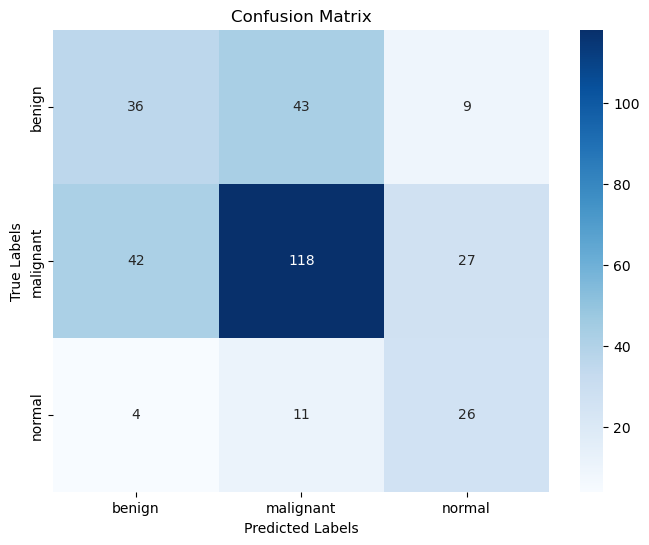

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score


# Reshape and flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Create and train the SVM model
svm_model = SVC(kernel='linear', C=1)  # You can adjust the hyperparameters as needed
svm_model.fit(train_images_flat, train_labels)

# Make predictions on the test data
test_predictions = svm_model.predict(test_images_flat)

#Calculate and display accuracy and confusion matrix
accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

#Calculate and display classification report
class_names = ["benign", "malignant", "normal"]
classification_rep = classification_report(test_labels, test_predictions, target_names=class_names)
print("Classification Report:")
print(classification_rep)

#Calculate and display Cohen's Kappa Score
kappa_score = cohen_kappa_score(test_labels, test_predictions)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [61]:
# Print sensitivity and specificity
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

Sensitivity (Recall): 0.5198
Specificity: 0.5556


In [66]:
# Calculate sensitivity and specificity for each class
sensitivity = []
specificity = []
for i in range(len(class_names)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = sum(sum(conf_matrix)) - (tp + fn + fp)

    sensitivity_class = tp / (tp + fn)
    specificity_class = tn / (tn + fp)
    
    sensitivity.append(sensitivity_class)
    specificity.append(specificity_class)

# Print sensitivity and specificity for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Sensitivity: {sensitivity[i]:.2f}")
    print(f"Specificity: {specificity[i]:.2f}")
    print()

Class: benign
Sensitivity: 0.57
Specificity: 0.73

Class: malignant
Sensitivity: 0.51
Specificity: 0.68

Class: normal
Sensitivity: 0.44
Specificity: 0.82



### SVM Model with Hyperparameters

In [ ]:
# Flatten the 4D image data into a 2D array
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

#Create the SVM model
svm_model = SVC()

#Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(train_images_flattened, train_labels)

#Get the best hyperparameters
best_params = grid_search.best_params_

# Train the SVM model with the best hyperparameters
best_svm_model = SVC(**best_params)
best_svm_model.fit(train_images_flattened, train_labels)

#Evaluate the model on the test data
test_accuracy = best_svm_model.score(test_images_flattened, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")

Classification Report:
               precision    recall  f1-score   support

      benign       0.76      0.48      0.59        88
   malignant       0.73      0.89      0.80       187
      normal       0.67      0.54      0.59        41

    accuracy                           0.73       316
   macro avg       0.72      0.63      0.66       316
weighted avg       0.73      0.73      0.71       316

Confusion Matrix:
 [[ 42  45   1]
 [ 11 166  10]
 [  2  17  22]]
Cohen's Kappa Score: 0.4674192094381405
Sensitivity (True Positive Rate):
 [0.47727273 0.88770053 0.53658537]
Specificity (True Negative Rate):
 [0.94298246 0.51937984 0.96      ]


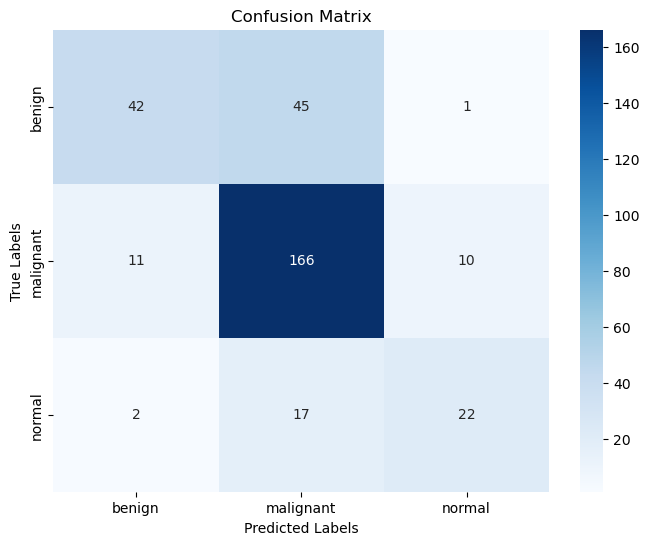

In [14]:
from sklearn.ensemble import RandomForestClassifier

#Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  
rf_model.fit(train_images_flat, train_labels)

#Make predictions on the test data
test_predictions = rf_model.predict(test_images_flat)

#Generate classification report and confusion matrix
class_names = ["benign", "malignant", "normal"]
classification_rep = classification_report(test_labels, test_predictions, target_names=class_names)
conf_matrix = confusion_matrix(test_labels, test_predictions)

#Calculate Cohen's Kappa score
cohen_kappa = cohen_kappa_score(test_labels, test_predictions)

#Calculate sensitivity and specificity
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives
true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

#Print the results
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print("Cohen's Kappa Score:", cohen_kappa)
print("Sensitivity (True Positive Rate):\n", sensitivity)
print("Specificity (True Negative Rate):\n", specificity)

#Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

#Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_images_flat, train_labels)

#Make predictions on the test data
predicted_labels = rf_model.predict(test_images_flat)

#Evaluate the model
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test accuracy: {accuracy}')

Test accuracy: 0.7278481012658228


### Random Forest with hyperparaeter

In [18]:
from sklearn.model_selection import GridSearchCV

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

#Create the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

#Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Perform grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_images_flat, train_labels)

# Best hyperparameters from grid search
best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

#Make predictions on the test data using the best model
best_rf_model = grid_search.best_estimator_
predicted_labels = best_rf_model.predict(test_images_flat)

#Evaluate the model
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test accuracy: {accuracy}')

#Visualize the confusion matrix and classification report
conf_matrix = confusion_matrix(test_labels, predicted_labels)
classification_rep = classification_report(test_labels, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test accuracy: 0.7278481012658228
Confusion Matrix:
[[ 42  45   1]
 [ 11 166  10]
 [  2  17  22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.48      0.59        88
           1       0.73      0.89      0.80       187
           2       0.67      0.54      0.59        41

    accuracy                           0.73       316
   macro avg       0.72      0.63      0.66       316
weighted avg       0.73      0.73      0.71       316



In [19]:
from sklearn.metrics import cohen_kappa_score

# True positives, false positives, true negatives, false negatives
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]
fn = conf_matrix[1, 0]

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Cohen's Kappa
kappa = cohen_kappa_score(test_labels, predicted_labels)

print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')

Sensitivity: 0.7375
Specificity: 0.4557
Cohen's Kappa: 0.4674


### Prediction of Breast Ultrasound Images

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
num_classes = len(label_encoder.classes_)
train_labels_encoded = to_categorical(train_labels_encoded, num_classes=num_classes)

# Split the data into training and validation sets
train_images, val_images, train_labels_encoded, val_labels_encoded = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels_encoded, epochs=10, validation_data=(val_images, val_labels_encoded))

# Save the trained model to a file
model.save('cnn_model.h5')

Epoch 1/10
26/26 [==============================] - 40s 1s/step - loss: 1.2612 - accuracy: 0.4820 - val_loss: 0.9608 - val_accuracy: 0.5495
Epoch 2/10
26/26 [==============================] - 43s 2s/step - loss: 0.7585 - accuracy: 0.6468 - val_loss: 0.7776 - val_accuracy: 0.6584
Epoch 3/10
26/26 [==============================] - 40s 2s/step - loss: 0.5694 - accuracy: 0.7658 - val_loss: 0.8909 - val_accuracy: 0.6733
Epoch 4/10
26/26 [==============================] - 39s 2s/step - loss: 0.4612 - accuracy: 0.8116 - val_loss: 0.8283 - val_accuracy: 0.6733
Epoch 5/10
26/26 [==============================] - 37s 1s/step - loss: 0.3401 - accuracy: 0.8600 - val_loss: 1.0332 - val_accuracy: 0.7129
Epoch 6/10
26/26 [==============================] - 36s 1s/step - loss: 0.2537 - accuracy: 0.9009 - val_loss: 1.1785 - val_accuracy: 0.7228
Epoch 7/10
26/26 [==============================] - 36s 1s/step - loss: 0.1449 - accuracy: 0.9566 - val_loss: 1.3977 - val_accuracy: 0.7475
Epoch 8/10
26/26 [==

In [86]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('cnn_model.h5')

# Load and preprocess the image
image_path = 'Dataset_BUSI_with_GT/benign/benign (1).png'  
img = image.load_img(image_path, target_size=(256, 256)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  

# Make predictions
predictions = model.predict(img_array)

# Interpret predictions
class_labels = ['normal', 'benign', 'malignant']
predicted_class = np.argmax(predictions[0])

# Get the predicted class label and probability
predicted_label = class_labels[predicted_class]
predicted_probability = predictions[0][predicted_class]

# Print the results
print(f"Predicted Class: {predicted_label}")
print(f"Class Probability: {predicted_probability:.4f}")

1/1 [==============================] - 0s 128ms/step
Predicted Class: benign
Class Probability: 0.8600


1/1 [==============================] - 0s 112ms/step


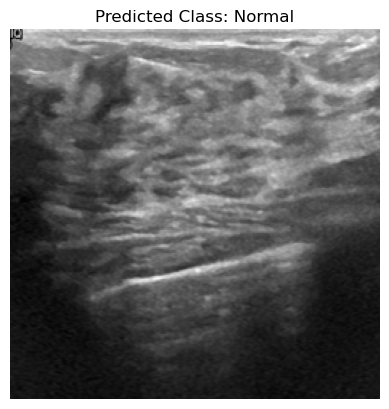

In [84]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

# Load the pre-trained model
model = load_model('cnn_model.h5')  

# Load and preprocess the image
image_path = 'Dataset_BUSI_with_GT/normal/normal (1).png'  
img = Image.open(image_path)
img = img.resize((256, 256))  
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(predictions[0])
class_labels = ['Normal', 'Benign ', 'Malignant']  

# Visualize the image and prediction
plt.imshow(img)
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

35363/35363 [==============================] - 0s 0us/step
1: aircraft_carrier (0.15)
2: submarine (0.10)
3: drilling_platform (0.07)


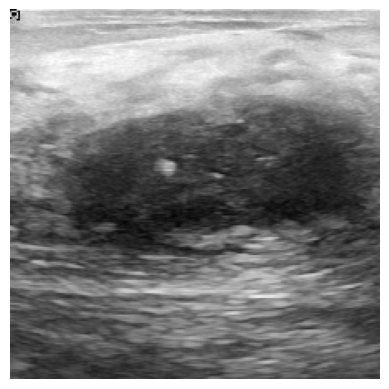

In [60]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# Load and preprocess the image
image_path = 'Dataset_BUSI_with_GT/malignant/malignant (1).png' 
img = image.load_img(image_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Load the pretrained VGG16 model
from tensorflow.keras.applications import VGG16
model = VGG16(weights='imagenet')

# Make predictions
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=3)[0]  

# Display the image and predictions
plt.imshow(img)
plt.axis('off')

for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

plt.show()

In [90]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('cnn_model.h5')

# Load and preprocess the image
image_path = 'Dataset_BUSI_with_GT/benign/benign (6).png'  
img = image.load_img(image_path, target_size=(256, 256)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(img_array)

# Interpret predictions
class_labels = ['normal', 'benign', 'malignant']
predicted_class = np.argmax(predictions[0])

# Get the predicted class label and probability
predicted_label = class_labels[predicted_class]
predicted_probability = predictions[0][predicted_class]

# Print the results
print(f"Predicted Class: {predicted_label}")
print(f"Class Probability: {predicted_probability:.4f}")

1/1 [==============================] - 0s 130ms/step
Predicted Class: benign
Class Probability: 1.0000
